In [1]:
from fractal.loaders.binance import BinancePriceLoader, BinanceFundingLoader
from fractal.loaders.base_loader import LoaderType
from datetime import datetime, timedelta, timezone
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from typing import Optional
from tqdm import tqdm
import time 
import warnings
warnings.filterwarnings("ignore")

### get data

In [2]:

class BinanceSpotPriceLoader(BinancePriceLoader):
    def __init__(
            self,
            ticker: str,
            loader_type: LoaderType = LoaderType.CSV,
            inverse_price: bool = False,
            interval: str = "1d",
            start_time: Optional[datetime] = None,
            end_time: Optional[datetime] = None,
            ):
        super().__init__(
            ticker,
            loader_type,
            inverse_price,
            interval,
            start_time,
            end_time,
        )
        self._url = "https://api.binance.com/api/v3/klines"


def get_futures_trading_tickers() -> list[dict]:
    url = "https://fapi.binance.com/fapi/v1/ticker/price"
    try:
        response = requests.get(url, timeout=10).json()
    except requests.exceptions.RequestException as e:
        raise SystemExit(e)
    return response


def get_spot_volumes() -> list[dict]:
    url = "https://api.binance.com/api/v3/ticker/24hr"
    url = (
        f"{url}?"
        f"&type=MINI"
    )
    try:
        response = requests.get(url, timeout=10).json()
    except requests.exceptions.RequestException as e:
        raise SystemExit(e)
    return response

In [3]:
def get_list_top_n_tickers(n_top_tickers) -> list:

    list_futures = get_futures_trading_tickers()
    futures = pd.DataFrame(list_futures)

    list_spots = get_spot_volumes()
    spot = pd.DataFrame(list_spots)

    df_spot_future = futures.merge(
        spot, 
        on='symbol', 
        how='inner'
    )[['symbol', 'count', 'volume']]

    df_spot_future = df_spot_future[
        df_spot_future['count'] > 0
    ].sort_values(by="count", ascending=False)

    futures_spot_tickers = df_spot_future['symbol'].to_list()[:n_top_tickers]

    return futures_spot_tickers


def download_spot_future_fr_data(
        futures_spot_tickers, 
        start_timestamp,
        end_timstamp,
        interval='1h'
    ) -> None:
    
    bad_tickers = []
    for ticker in tqdm(futures_spot_tickers):
        try:
            # Download spot data
            binance_spot_kandle_loader = BinanceSpotPriceLoader(
                ticker=ticker,
                start_time=start_timestamp,
                end_time=end_timstamp,
                interval=interval,
                loader_type=LoaderType.CSV
            )
            binance_spot_kandle_loader.read(with_run=True)
            time.sleep(1)

            # Download future data
            binance_future_kandle_loader = BinancePriceLoader(
                ticker=ticker,
                start_time=start_timestamp,
                end_time=end_timstamp,
                interval=interval,
                loader_type=LoaderType.CSV
            )
            binance_future_kandle_loader.read(with_run=True)
            time.sleep(1)

            # Download funding rate
            binance_funding_rate_loader = BinanceFundingLoader(
                ticker=ticker,
                start_time=start_timestamp,
                end_time=end_timstamp,
                loader_type=LoaderType.CSV
            )
            binance_funding_rate_loader.read(with_run=True)
        except:
            bad_tickers.append(ticker)

In [4]:
current_time = datetime(
    year = 2025, 
    month = 4, 
    day = 16
)
years = 1
delta = timedelta(days=365 * years)
start_time = current_time - delta

In [5]:
list_top_n_tickers = get_list_top_n_tickers(50)

In [5]:
list_top_n_tickers = ['BTCUSDT',
 'ETHUSDT',
 'SOLUSDT',
 'TRUMPUSDT',
 'DOGEUSDT',
 'SUIUSDT',
 'ETHUSDC', 
'LTCUSDT'
]

In [6]:
download_spot_future_fr_data(
    futures_spot_tickers=list_top_n_tickers, 
    start_timestamp=start_time,
    end_timstamp=current_time,
    interval='5m'
)

100%|██████████| 8/8 [20:22<00:00, 152.77s/it]


### process data

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
def process_ticker(ticker_name):

    df_futr = pd.read_csv(f'./fractal_data/binancepriceloader/{ticker_name}.csv', sep=',', index_col=0)
    df_spot = pd.read_csv(f'./fractal_data/binancespotpriceloader/{ticker_name}.csv', sep=',', index_col=0)
    df_rate = pd.read_csv(f'./fractal_data/binancefundingloader/{ticker_name}.csv', sep=',', index_col=0)

    df_futr.rename(columns={
        'openTime': 'open_time',
        'open': 'open_futr',
        'high': 'high_futr',
        'low': 'low_futr',
        'close': 'close_futr',
        'volume': 'volume_futr'
        }, inplace=True)
    df_spot.rename(columns={
        'openTime': 'open_time',
        'open': 'open_spot',
        'high': 'high_spot',
        'low': 'low_spot',
        'close': 'close_spot',
        'volume': 'volume_spot'
        }, inplace=True)
    df_rate.rename(columns={
        'fundingTime': 'open_time',
        }, inplace=True)
    
    df = df_spot.merge(df_futr, on='open_time', how='left')
    df = df.merge(df_rate, on='open_time', how='left')

    df['open_time'] = df['open_time'].str[:-6]
    df.sort_values(by='open_time', ascending=False, inplace=True)
    df.drop(columns=['ticker'], inplace=True)
    
    df['fundingRate'].ffill(inplace=True)
    df.dropna(inplace=True)
    df.sort_values(by='open_time', ascending=True, inplace=True)

    return df

In [10]:
data = {}
for ticker in tqdm(list_top_n_tickers):
    try:
        df_tmp = process_ticker(ticker)
        data[ticker] = df_tmp
    except:
        pass

100%|██████████| 8/8 [00:01<00:00,  4.34it/s]


In [45]:
def extract_features(df, current_idx):
    t = int(df.loc[current_idx, 'hour_index'] * 8 + int(df.loc[current_idx, 'open_time'][14:16]))
    window = df.iloc[current_idx:current_idx+t]

    features = {
        'log_return': np.log(window['close_spot'].iloc[-1] / window['close_spot'].iloc[0]),
        'volatility': window['close_spot'].pct_change().std(),
        'avg_volume_futr': window['volume_futr'].mean(),
        'avg_volume_spot': window['volume_spot'].mean(),
        'basis_mean': (window['close_futr'] - window['close_spot']).mean(),
        'basis_std': (window['close_futr'] - window['close_spot']).std(),
    }

    return pd.Series(features)

In [12]:
def rsi(data, period=14):
    delta = data['close_futr'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return 100 - (100 / (1 + rs))

def mfi(data, period=14):
    typical_price = (data['high_futr'] + data['low_futr'] + data['close_futr']) / 3
    money_flow = typical_price * data['volume_futr']
    positive_flow = money_flow.where(typical_price.diff() > 0, 0)
    negative_flow = money_flow.where(typical_price.diff() < 0, 0)
    pos_flow_sum = positive_flow.rolling(window=period).sum()
    neg_flow_sum = negative_flow.rolling(window=period).sum()
    mfi = 100 - (100 / (1 + (pos_flow_sum / neg_flow_sum)))
    return mfi

def ema(data, period):
    alpha = 2 / (period + 1)
    ema_values = [data['close_futr'][0]]
    for price in data['close_futr'][1:]:
        ema_values.append((price * alpha) + (ema_values[-1] * (1 - alpha)))
    return pd.Series(ema_values, index=data.index)

In [40]:
df = data['LTCUSDT'].copy()

In [41]:
df['fundingRate'] = df['fundingRate'].shift(-1)
df = df.iloc[:-1]
df['hour_index'] = df['open_time'].str[11:13].astype(int) % 8 + 1

In [46]:
features_df = pd.DataFrame([extract_features(df, i) for i in range(len(df))])

In [47]:
df = df[~((df['open_time'].str[14:16] >= '55') &  ((df['open_time'].str[11:13].astype(int) % 8 + 1) == 8))]

In [48]:
df['basis'] = df['close_futr'] - df['close_spot']
df['volume_ratio'] = df['volume_futr'] / df['volume_spot']
df = pd.concat([df, features_df], axis=1)

In [50]:
df['sma_fr_7'] = df.fundingRate.rolling(8 * 7).mean().shift(1)
df['sma_fr_3'] = df.fundingRate.rolling(8 * 3).mean().shift(1)

In [51]:
df['sma_basis_14'] = df['basis'].rolling(14).mean().shift(1)
df['sma_basis_7'] = df['basis'].rolling(7).mean().shift(1)
df['sma_basis_3'] = df['basis'].rolling(3).mean().shift(1)

In [52]:
window = 7
df[f'EMA_{window}'] = ema(df, window)
df[f'RSI_{window}'] = rsi(df, window)
df[f'MFI_{window}'] = mfi(df, window)
window = 14
df[f'EMA_{window}'] = ema(df, window)
df[f'RSI_{window}'] = rsi(df, window)
df[f'MFI_{window}'] = mfi(df, window)
window = 28
df[f'EMA_{window}'] = ema(df, window)
df[f'RSI_{window}'] = rsi(df, window)
df[f'MFI_{window}'] = mfi(df, window)

In [53]:
df['basis_relative'] = df['basis'] / df['close_futr']

In [54]:
df['target'] = df['basis'].shift(1)

In [55]:
df = df.iloc[8*5:]

In [21]:
df = df[df['hour_index'] != 8]

In [56]:
cols = [
    'log_return', 'volatility', 'avg_volume_futr', 'avg_volume_spot',
    'basis_mean', 'basis_std', 'hour_index', 'volume_ratio',
    'sma_fr_3', 'sma_fr_7',
    'sma_basis_3', 'sma_basis_7', 'sma_basis_14',
    'RSI_7', 'MFI_7', 'EMA_7', 
    'RSI_14', 'MFI_14', 'EMA_14',
    'RSI_28', 'MFI_28', 'EMA_28',
]
train_size = int(df.shape[0] * 0.8)
x = df.iloc[:train_size][cols]
y = df.iloc[:train_size]['target']

test = df.iloc[train_size:]
x_test = df.iloc[train_size:][cols]
y_test = df.iloc[train_size:]['target']

In [57]:
kwargs = {'iterations': 200, 'depth': 4, 'verbose': False}
model = CatBoostRegressor(**kwargs)
model.fit(x, y)

In [92]:
feats = pd.DataFrame()
feats['feature'] = model.feature_names_
feats['importance'] = model.feature_importances_
feats.sort_values(by='importance', ascending=False)

,feature,importance
10,sma_basis_3,62.088495
11,sma_basis_7,15.571717
12,sma_basis_14,14.355988
18,EMA_14,5.962628
9,sma_fr_7,1.211488
4,basis_mean,0.129035
13,RSI_7,0.093138
21,EMA_28,0.070407
14,MFI_7,0.056404
7,volume_ratio,0.054918


array([3.91914540e-02, 3.37987719e-02, 4.65350503e-02, 1.50444207e-02,
       1.29035363e-01, 3.55745558e-02, 4.80154484e-03, 5.49179020e-02,
       7.89646603e-03, 1.21148792e+00, 6.20884952e+01, 1.55717166e+01,
       1.43559877e+01, 9.31376305e-02, 5.64039779e-02, 5.06728510e-02,
       5.39747256e-02, 4.49416577e-02, 5.96262771e+00, 3.61641656e-02,
       3.71873728e-02, 7.04069359e-02])

In [58]:
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [59]:
preds_train = model.predict(x)
mean_absolute_percentage_error(y, preds_train), smape(y, preds_train)

(1160030708142.6086, 0.27143145155798815)

In [60]:
kwargs = {'iterations': 20, 'depth': 1, 'verbose': False}
model_fr = CatBoostRegressor(**kwargs)
model_fr.fit(preds_train, df.iloc[:train_size].fundingRate)

In [61]:
preds = model.predict(x_test)
preds_fr = model_fr.predict(preds)

test['preds'] = preds
test['preds_fr'] = preds_fr

In [69]:
test = test.iloc[:-2000]

In [70]:
mean_absolute_percentage_error(test['target'], test['preds']), smape(test['target'], test['preds'])

(94086941692.4925, 0.16706148801619833)

In [71]:
print(mean_absolute_percentage_error(test[test['fundingRate'] != 0.0001]['target'], test[test['fundingRate'] != 0.0001]['preds']))
print(smape(test[test['fundingRate'] != 0.0001]['target'], test[test['fundingRate'] != 0.0001]['preds']))

34793731378.29823
0.15769909908918492


In [ ]:
train = df.iloc[:train_size]
train['preds'] = model.predict(x)

train['bin_preds'] = pd.qcut(train['preds'], q=20)
train.groupby('bin_preds')['fundingRate'].agg(['count', 'mean'])

,count,mean
bin_preds,,
"(-2.4339999999999997, -0.0601]",4200,0.000049
"(-0.0601, -0.0529]",4199,0.000051
"(-0.0529, -0.0497]",4199,0.000050
"(-0.0497, -0.0469]",4200,0.000054
"(-0.0469, -0.0432]",4199,0.000055
"(-0.0432, -0.0418]",4199,0.000058
"(-0.0418, -0.04]",4200,0.000059
"(-0.04, -0.0368]",4199,0.000065
"(-0.0368, -0.0358]",4199,0.000065


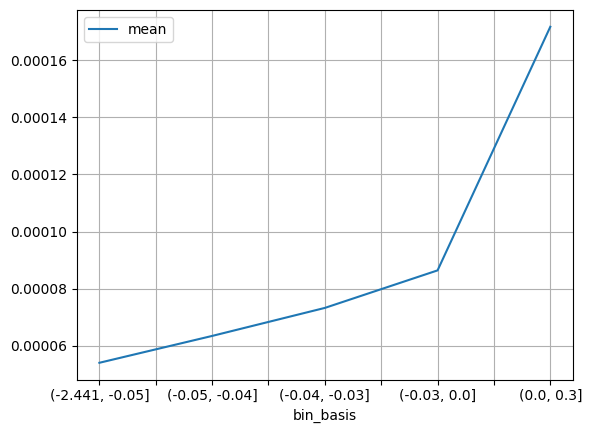

In [106]:
train['bin_basis'] = pd.qcut(train['basis'], q=5)
train.groupby('bin_basis')['fundingRate'].agg(['mean']).plot()
plt.grid()

In [73]:
train['bin_preds'] = pd.qcut(train['preds'], q=50)
mapping = train.groupby('bin_preds')['fundingRate'].agg(['mean'])
mapping = mapping.to_dict()

In [75]:
test['bin_preds'] = pd.qcut(test['preds'], q=10)
test.groupby('bin_preds')['fundingRate'].agg(['count', 'mean'])

,count,mean
bin_preds,,
"(-0.186, -0.0822]",1900,0.000012
"(-0.0822, -0.0719]",1900,0.000020
"(-0.0719, -0.0674]",1899,0.000022
"(-0.0674, -0.0604]",1900,0.000030
"(-0.0604, -0.0562]",1900,0.000036
"(-0.0562, -0.0506]",1899,0.000041
"(-0.0506, -0.0468]",1900,0.000051
"(-0.0468, -0.0416]",1899,0.000056
"(-0.0416, -0.0356]",1900,0.000063


In [76]:
def process_prediction(x, mapping):
    prediction = x
    for key, value in mapping['mean'].items():
        left = key.left
        right = key.right
        if prediction > left and prediction < right:
            return value
    return 0.0001

In [78]:
train['preds_fr'] = train['preds'].map(lambda x: process_prediction(x, mapping))
print(smape(train.fundingRate, [0.0001] * len(train)))
print(smape(train.fundingRate, [train.fundingRate.mean()] * len(train)))
print(smape(train.fundingRate, train.fundingRate.rolling(8*12*5).mean().shift(8).iloc[8*5+1:]))
print(smape(train.fundingRate, train['preds_fr']))

0.45229153583687526
0.49310302520095634
0.45095753109429526
0.47824894411765845


In [79]:
for i in range(1, 8):
    mape = smape(test[test['hour_index'] == i]['target'], test[test['hour_index'] == i]['preds'])
    print(i, mape)

1 0.1698701624910917
2 0.15921154908111196
3 0.1654351258923943
4 0.1613496135963634
5 0.16663731010795235
6 0.1643238398072572
7 0.1781516840129125


In [80]:
test['preds_fr'] = test['preds'].map(lambda x: process_prediction(x, mapping))
smape(test.fundingRate, test['preds_fr'])

0.8315018377980545

In [88]:
for i in range(1, 8):
    mape = smape(test[test['hour_index'] == i]['fundingRate'], test[test['hour_index'] == i]['preds_fr'])
    print(i, mape)

1 0.8437623147378682
2 0.8402489411817365
3 0.8404820732129499
4 0.829919653861008
5 0.8216444795278107
6 0.8233711133946735
7 0.8259091327332955


In [81]:
smape(test.fundingRate, [0.0001] * len(test))

0.840328095320128

In [82]:
smape(test.fundingRate, [test.fundingRate.mean()] * len(test))

0.9290422854151568

In [84]:
smape(test.fundingRate, test.fundingRate.rolling(8*12 * 3).mean().shift(7).iloc[7+1:])

0.8519681885572109

In [109]:
np.corrcoef(test.preds, test.basis)

array([[1.        , 0.67460034],
       [0.67460034, 1.        ]])

In [110]:
np.corrcoef(train.preds, train.basis)

array([[1.        , 0.91652086],
       [0.91652086, 1.        ]])

In [107]:
np.corrcoef(test.fundingRate, test.preds)

array([[1.        , 0.31767463],
       [0.31767463, 1.        ]])

In [108]:
np.corrcoef(train.fundingRate, train.preds)

array([[1.        , 0.69555788],
       [0.69555788, 1.        ]])

In [87]:
np.corrcoef(test.fundingRate, test.preds_fr)

array([[1.        , 0.29685028],
       [0.29685028, 1.        ]])

In [ ]:

ax.plot(funding_true, label='True Funding Rate', color='black')
ax.plot(baseline_predictions[name], linestyle='--', label=f'Prediction: {name}')
ax.set_title(f'{name} vs True')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

Два варианта кластеризации:
1. по фичам, извлеченным из funding rate
2. по рыночным индикаторам, извлеченным из цены актива (относительные, как MFI, RSI и т.д.)

In [10]:
df = data['ADAUSDT']

train_size = int(df.shape[0] * 0.8)
df = df.iloc[1:train_size]
df = df.iloc[7::8]

In [32]:
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf, pacf

In [116]:
def extract_time_series_features(funding_rate_series: pd.Series) -> dict:
    series = funding_rate_series.dropna()
    mean_rate = series.abs().mean()
    features = {}

    norm = lambda x: x / mean_rate

    # 1. Волатильность за весь период
    features['std'] = norm(series.std())
    features['mean_abs_change'] = norm(series.diff().abs().mean())

    # 2. Автокорреляции (до 3 лага)
    acf_values = acf(series, nlags=3, fft=False)
    for i in range(1, 4):
        features[f'acf_lag{i}'] = acf_values[i]

    # 3. Тренд — линейная регрессия
    x = np.arange(len(series))
    slope, intercept, r_value, p_value, std_err = linregress(x, series)
    features['trend_slope'] = norm(slope)
    features['trend_r2'] = r_value ** 2

    # 4. Скользящие std и mean
    features['rolling_std_24'] = norm(series.rolling(24).std().mean())
    features['rolling_mean_24'] = norm(series.rolling(24).mean().mean())

    # 5. Кол-во смен знака (индикатор смены настроений)
    signs = np.sign(series)
    features['sign_changes'] = (signs != signs.shift(1)).sum() / series.shape[0]

    # 6. Пики/всплески (аномалии)
    zscores = (series - series.mean()) / series.std()
    features['spike_count_z3'] = (np.abs(zscores) > 3).sum() / series.shape[0]

    # 7. Коэффициент асимметрии и эксцесса
    features['skew'] = series.skew()
    features['kurtosis'] = series.kurt()

    # 8. Возврат к среднему (mean reversion): autocorr на 1 шаг вперёд
    features['mean_reversion_strength'] = -acf_values[1]  # сильная отриц. автокорреляция → возврат

    return features

In [117]:
features_list = []
tickers = []

for ticker, df in data.items():

    if df.shape[0]:
        train_size = int(df.shape[0] * 0.8)
        df = df.iloc[1:train_size]
        df = df.iloc[7::8]

        if df.shape[0] <= 300:
            print(ticker)
            continue

        fr_series = df['fundingRate']
        feats = extract_time_series_features(fr_series)

        if feats:
            features_list.append(feats)
            tickers.append(ticker)
    else:
        print(ticker)

features_df = pd.DataFrame(features_list, index=tickers)

WCTUSDT
GUNUSDT
BABYUSDT
LAYERUSDT
BIGTIMEUSDT
KERNELUSDT
TRUMPUSDT
REDUSDT
BERAUSDT
PENGUUSDT
KAITOUSDT
DEXEUSDT
HBARUSDC
FUNUSDT
BIOUSDT
FORMUSDT


In [91]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
features_df.head()

,std,mean_abs_change,acf_lag1,acf_lag2,acf_lag3,trend_slope,trend_r2,rolling_std_24,rolling_mean_24,sign_changes,spike_count_z3,skew,kurtosis,mean_reversion_strength
SOLUSDT,1.057794,0.543028,0.632255,0.569776,0.572462,0.000070,0.000281,0.668016,0.827856,0.219429,0.021714,0.439668,11.959250,-0.632255
MEMEUSDT,0.807365,0.405670,0.466806,0.322068,0.282822,-0.001177,0.040035,0.580748,0.751502,0.136842,0.031579,-2.666825,9.780792,-0.466806
ETHUSDT,0.726729,0.299383,0.751267,0.677566,0.662993,0.000719,0.062586,0.370212,0.977511,0.065143,0.020571,1.996639,9.742366,-0.751267
BTCUSDT,0.831606,0.353806,0.700433,0.603016,0.590142,0.000823,0.062505,0.459847,0.925262,0.115429,0.014857,2.124612,15.644963,-0.700433
XRPUSDT,0.828963,0.453611,0.577581,0.464757,0.380358,0.000579,0.031183,0.555962,0.918307,0.150857,0.020571,2.074216,14.054786,-0.577581


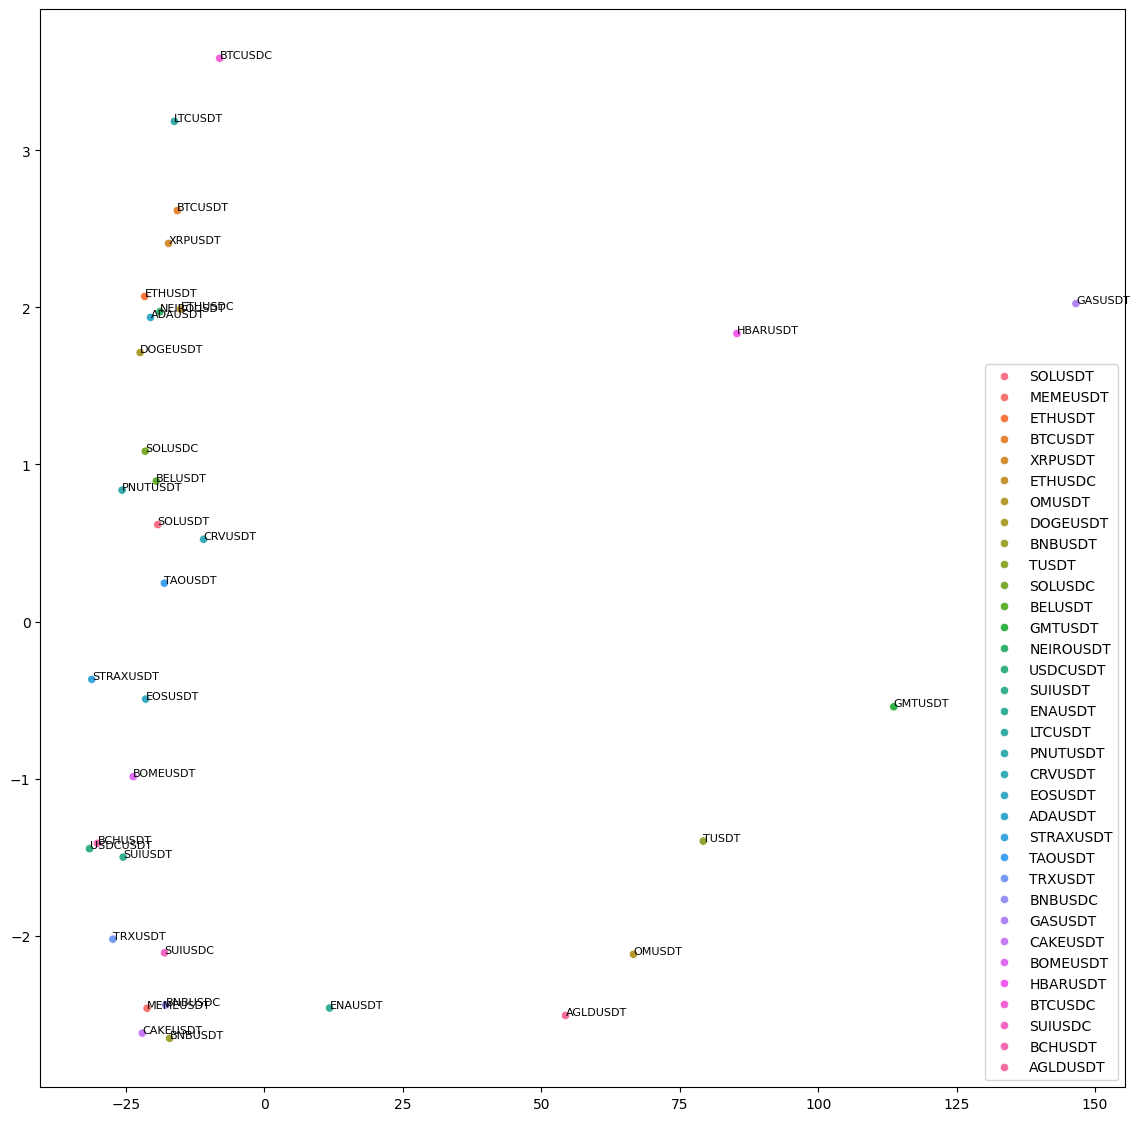

In [119]:
pca = PCA(n_components=2)
components = pca.fit_transform(features_df)

plt.figure(figsize=(14, 14))

sns.scatterplot(x=components[:,0], y=components[:,1], hue=features_df.index.to_list())
for i, ticker in enumerate(features_df.index):
    plt.text(components[i,0], components[i,1], ticker, fontsize=8)

plt.savefig('images/clusters_PCA.png')

In [120]:
features_df.head()

,std,mean_abs_change,acf_lag1,acf_lag2,acf_lag3,trend_slope,trend_r2,rolling_std_24,rolling_mean_24,sign_changes,spike_count_z3,skew,kurtosis,mean_reversion_strength
SOLUSDT,1.057794,0.543028,0.632255,0.569776,0.572462,0.000070,0.000281,0.668016,0.827856,0.219429,0.021714,0.439668,11.959250,-0.632255
MEMEUSDT,0.807365,0.405670,0.466806,0.322068,0.282822,-0.001177,0.040035,0.580748,0.751502,0.136842,0.031579,-2.666825,9.780792,-0.466806
ETHUSDT,0.726729,0.299383,0.751267,0.677566,0.662993,0.000719,0.062586,0.370212,0.977511,0.065143,0.020571,1.996639,9.742366,-0.751267
BTCUSDT,0.831606,0.353806,0.700433,0.603016,0.590142,0.000823,0.062505,0.459847,0.925262,0.115429,0.014857,2.124612,15.644963,-0.700433
XRPUSDT,0.828963,0.453611,0.577581,0.464757,0.380358,0.000579,0.031183,0.555962,0.918307,0.150857,0.020571,2.074216,14.054786,-0.577581


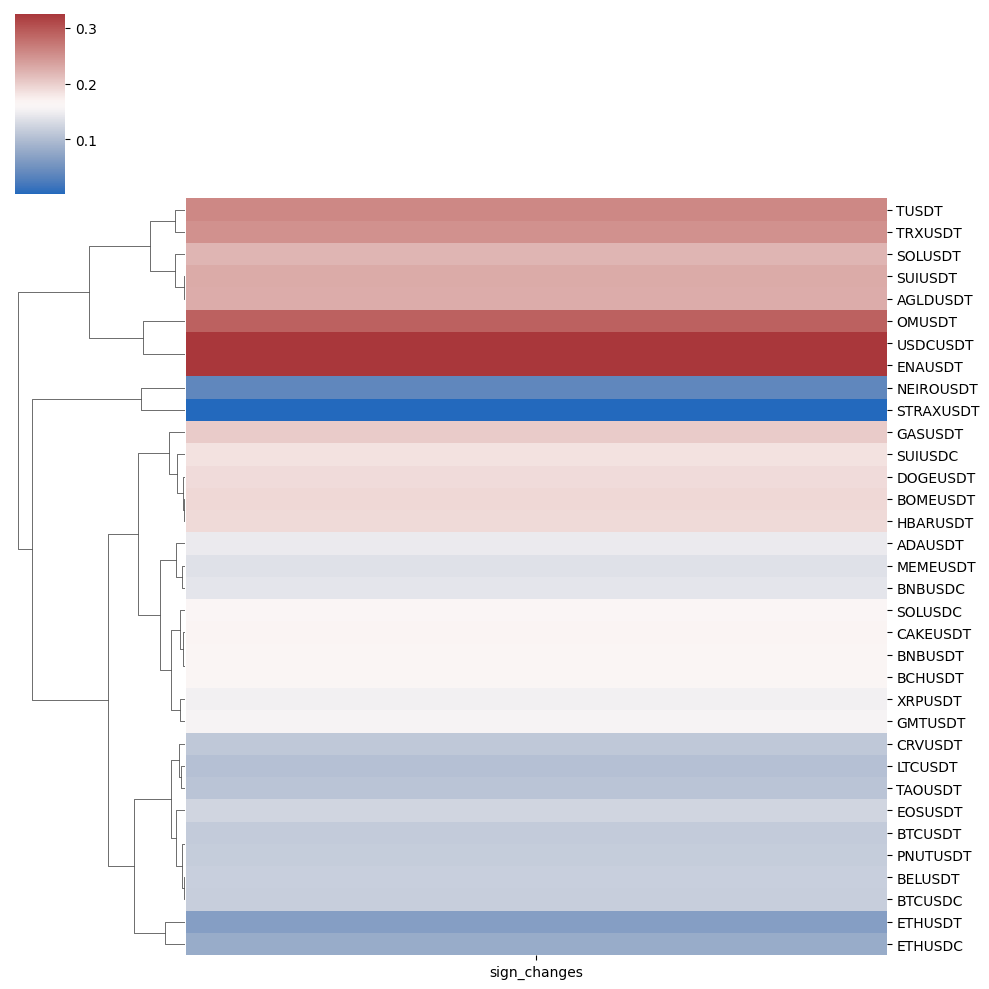

In [121]:
sns.clustermap(features_df['sign_changes'], cmap="vlag", col_cluster=False)
plt.savefig('images/heatmap_sign_changes.png')

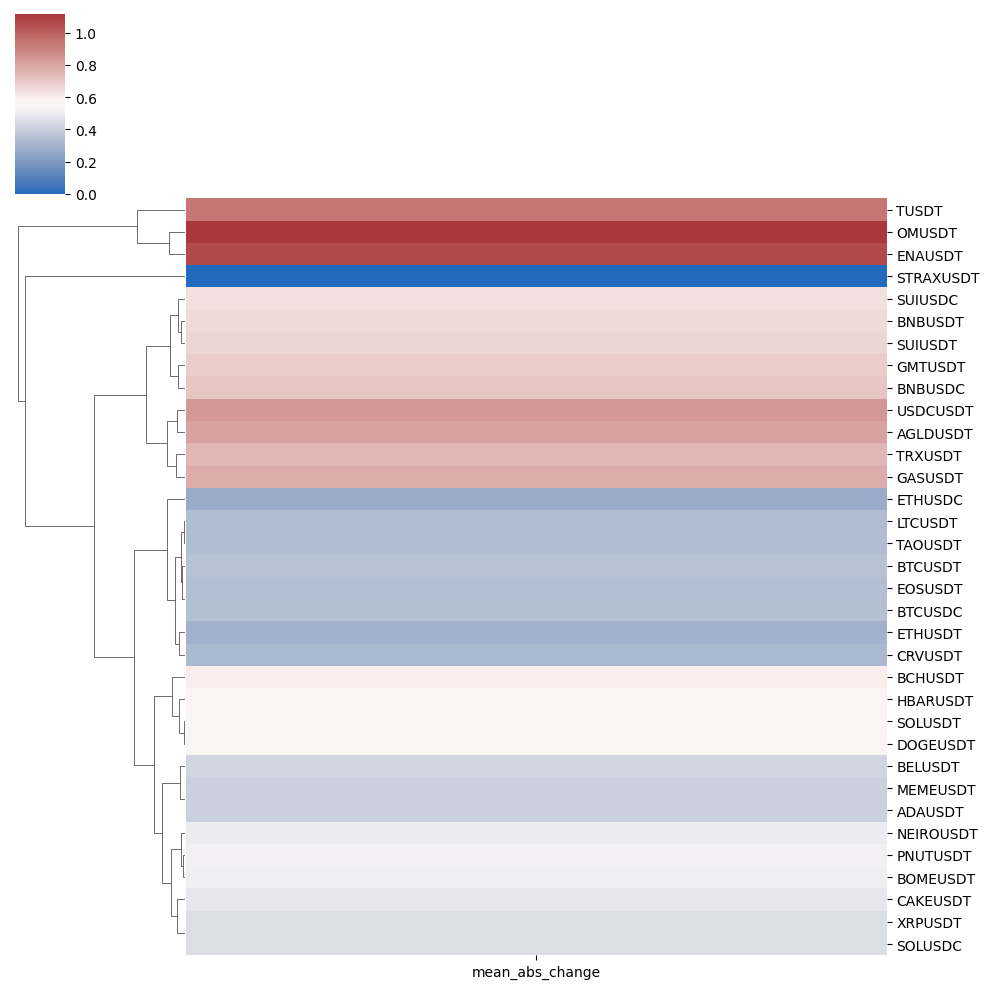

In [ ]:
# lst_idx = ['BNBUSDC', 'USDCUSDT', 'TRXUSDT', 'BNBUSDT'] .loc[~features_df.index.isin(lst_idx)]
sns.clustermap(features_df['mean_abs_change'], cmap="vlag", col_cluster=False)
plt.savefig('images/heatmap_mean_fr_change.png')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [127]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

In [129]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_scaled)

features_df['cluster'] = cluster_labels

In [131]:
embedding = TSNE(n_components=2, random_state=42).fit_transform(features_scaled)

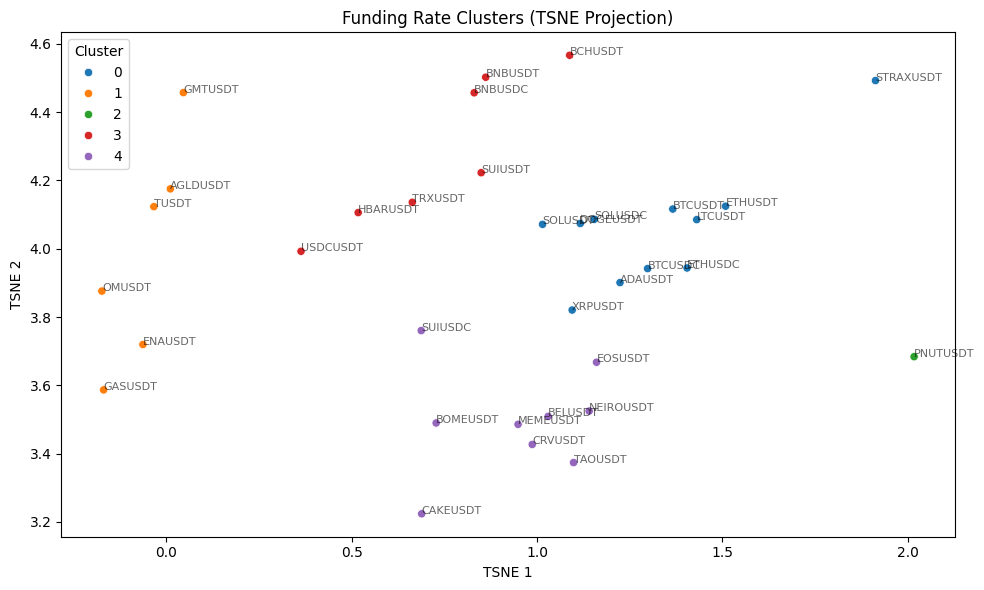

In [141]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels, palette='tab10')
for i, ticker in enumerate(tickers):
    plt.text(embedding[i, 0], embedding[i, 1], ticker, fontsize=8, alpha=0.6)
plt.title("Funding Rate Clusters (TSNE Projection)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Cluster", loc='best')
plt.tight_layout()
plt.savefig('images/clusters_TSNE_KMeans.png')
plt.show()

In [136]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering
import hdbscan

In [137]:
def plot_clusters(embedding, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', legend='full')
    for i, ticker in enumerate(tickers):
        plt.text(embedding[i, 0], embedding[i, 1], ticker, fontsize=8, alpha=0.5)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster", loc="best")
    plt.tight_layout()
    plt.show()

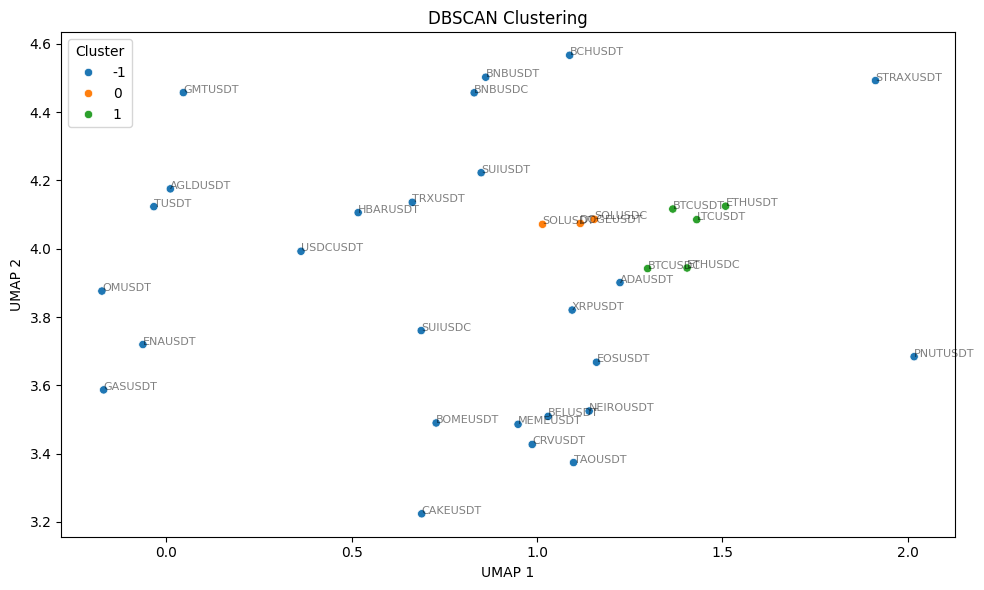

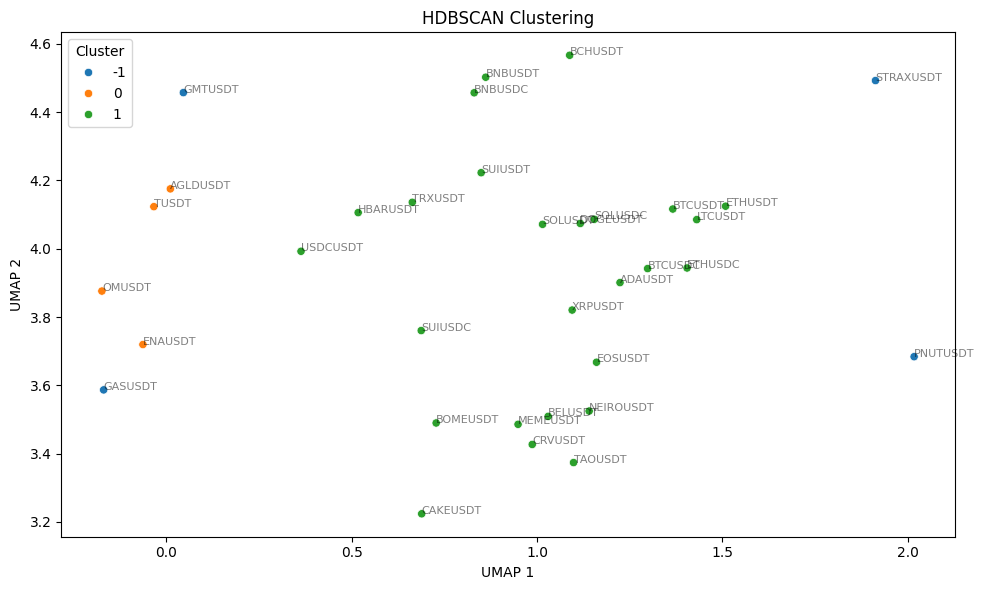

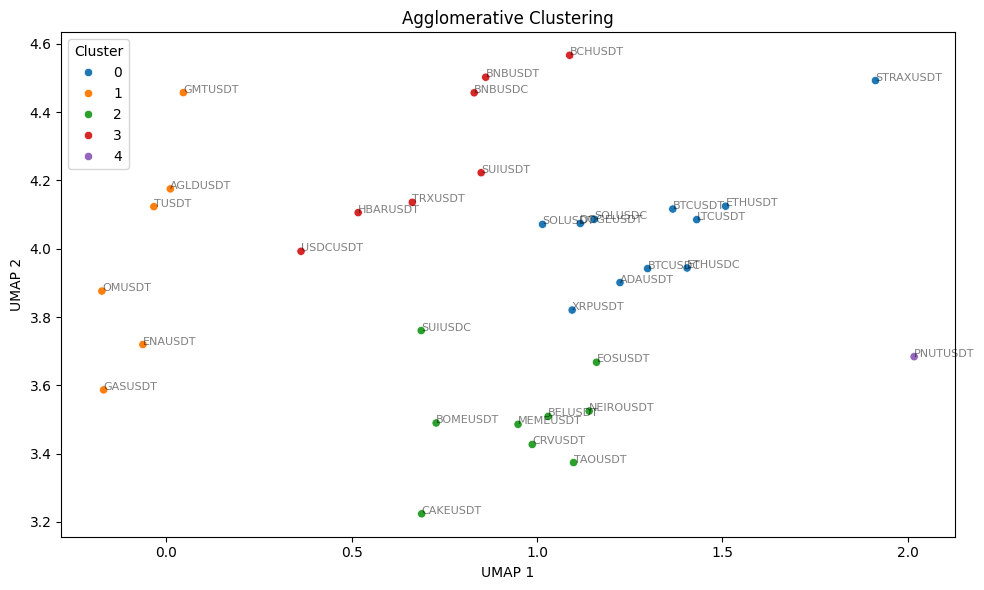

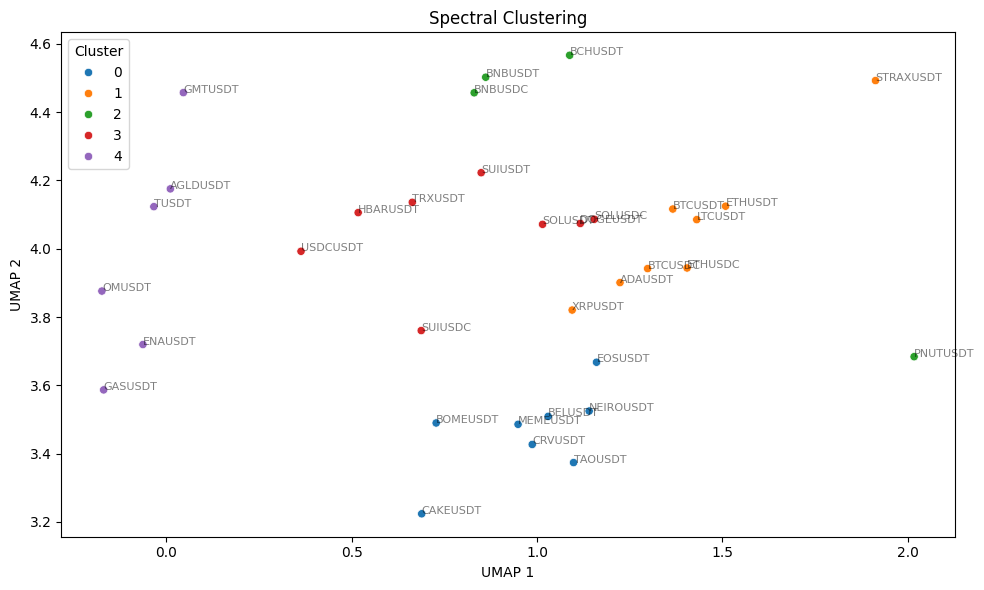

In [138]:
# --- DBSCAN ---
dbscan = DBSCAN(eps=1.2, min_samples=3)
db_labels = dbscan.fit_predict(features_scaled)
plot_clusters(embedding, db_labels, "DBSCAN Clustering")

# --- HDBSCAN ---
hdb = hdbscan.HDBSCAN(min_cluster_size=3)
hdb_labels = hdb.fit_predict(features_scaled)
plot_clusters(embedding, hdb_labels, "HDBSCAN Clustering")

# --- Agglomerative Clustering ---
agg = AgglomerativeClustering(n_clusters=5)
agg_labels = agg.fit_predict(features_scaled)
plot_clusters(embedding, agg_labels, "Agglomerative Clustering")

# --- Spectral Clustering ---
spectral = SpectralClustering(n_clusters=5, assign_labels="discretize", random_state=42)
spectral_labels = spectral.fit_predict(features_scaled)
plot_clusters(embedding, spectral_labels, "Spectral Clustering")

In [ ]:
df['open_futr_spot_diff'] = df['open_futr'] - df['open_spot']

In [8]:
tmp = df[df['fundingRate'].notna()]

np.corrcoef(tmp.fundingRate, tmp.open_futr_spot_diff)

array([[1.        , 0.61572545],
       [0.61572545, 1.        ]])

In [9]:
df['fundingRate'].ffill(inplace=True)

/tmp/ipykernel_43335/4279684744.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fundingRate'].ffill(inplace=True)


In [10]:
df.dropna(inplace=True)

In [11]:
df['open_futr_spot_relative_percentage_diff'] = df['open_futr_spot_diff'] / df['open_futr'] * 100

In [12]:
tmp = df[df['fundingRate'].notna() & (df['fundingRate'] < 0.0001)]

np.corrcoef(tmp.fundingRate, tmp.open_futr_spot_diff)

array([[1.       , 0.1199426],
       [0.1199426, 1.       ]])

In [13]:
df.sort_values(by='open_time', ascending=True, inplace=True)

train_size = int(df.shape[0] * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [46]:
def get_ARIMA_forecast(train_data):
    model = SARIMAX(
        train_data,
        order=(2, 0, 0),  # (p, d, q): AR(5)
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=1)
    predicted_mean = forecast.predicted_mean
    return predicted_mean

target = 'open_futr_spot_relative_percentage_diff'
history = list(train[target])
preds = []
for t in tqdm(range(len(test))):
    forecast = get_ARIMA_forecast(history)
    preds.append(forecast[0])
    history.append(test[target].iloc[t])

100%|██████████| 1751/1751 [06:32<00:00,  4.46it/s]


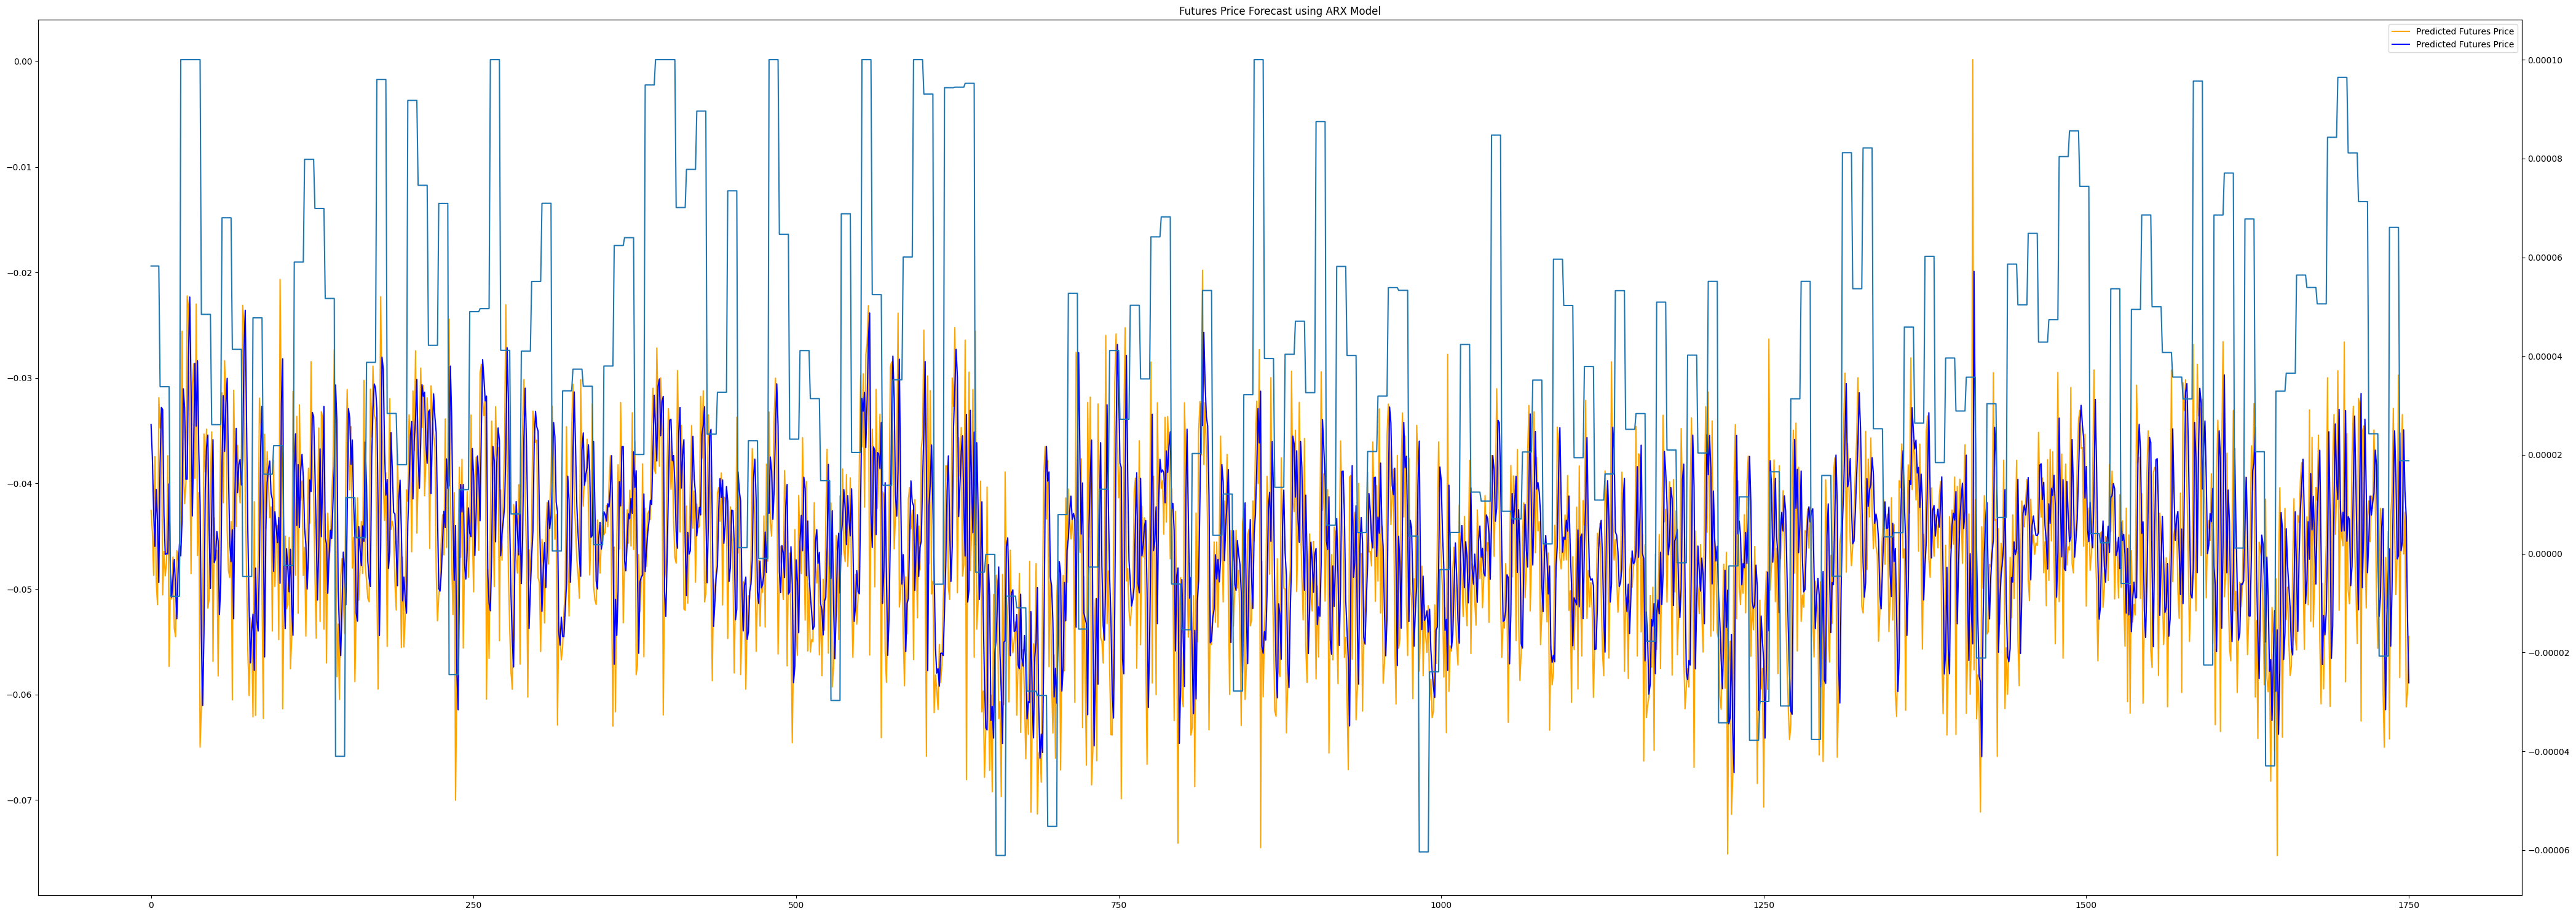

In [54]:
n = len(preds)
true_label = test.open_futr_spot_relative_percentage_diff.iloc[:n]

fig, ax = plt.subplots(1, 1, figsize=(42, 15))
ax.plot(range(n), true_label, label='Predicted Futures Price', color='orange')
ax.plot(range(n), preds, label='Predicted Futures Price', color='blue')
ax1 = ax.twinx()
ax1.plot(range(n), test.fundingRate)
ax.set_title('Futures Price Forecast using ARX Model')
ax.legend()
plt.tight_layout()
plt.show()

In [50]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(true_label, preds)

0.3661969442033697

In [42]:
train['bin_percentage_diff'] = pd.qcut(train['open_futr_spot_relative_percentage_diff'], q=20)

In [45]:
train.groupby('bin_percentage_diff')['fundingRate'].mean().to_frame()

,fundingRate
bin_percentage_diff,
"(-0.0992, -0.06]",-0.000001
"(-0.06, -0.0558]",0.000016
"(-0.0558, -0.0525]",0.000029
"(-0.0525, -0.05]",0.000030
"(-0.05, -0.0478]",0.000040
"(-0.0478, -0.0457]",0.000045
"(-0.0457, -0.0438]",0.000048
"(-0.0438, -0.0419]",0.000056
"(-0.0419, -0.0397]",0.000062


In [ ]:
train